In [1]:
### This program computes eff frontier wts using training set but based on denoised covariance. Then use wts on testset.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
### We can import the data set. The dataframe name is now df
dftech = pd.read_csv('ret_porttech.csv',index_col=[0]) ### index_col=[0] removes default unnamed index column
dfecom = pd.read_csv('ret_portecom.csv',index_col=[0])
dffood = pd.read_csv('ret_portfood.csv',index_col=[0])
dfcov = pd.read_csv('denoised_cov.csv',index_col=[0]) ### reads in the denoised cov

In [3]:
dfmerge = pd.merge(dftech,dfecom, on = ['day', 'month','year'])
dfmerge.columns=['BroadR','IntelR','MicroCR','MicronR','QualR','SamR','SKR','SMICR','day','month',
                 'year','AliR','AmazR','EbayR','RakR','SunR','WayR','ZalR','JDR'] ### Rename the columns
dfmerge = pd.merge(dfmerge,dffood, on = ['day', 'month','year'])

In [4]:
print(dfmerge)

        BroadR    IntelR   MicroCR   MicronR     QualR      SamR       SKR  \
0    -0.007147 -0.005204 -0.000470 -0.008461  0.001070 -0.008811 -0.016000   
1    -0.015882 -0.001649 -0.019461 -0.011244  0.001221 -0.016732  0.009631   
2     0.013167  0.003570  0.017265 -0.003171 -0.000305  0.017838  0.022118   
3     0.002150  0.003557  0.011554  0.013520  0.001830  0.027787  0.031781   
4     0.020138 -0.001914  0.006653  0.006247 -0.000305  0.000538  0.004028   
...        ...       ...       ...       ...       ...       ...       ...   
1108  0.013770  0.003932  0.011997 -0.003756  0.009974  0.016508  0.019881   
1109  0.014546  0.006648  0.006463  0.044173  0.007470  0.006278  0.003929   
1110  0.006298  0.008732  0.012574 -0.015799  0.011318  0.004994  0.000000   
1111  0.005382  0.001352  0.002383  0.034163  0.007439 -0.014351  0.008223   
1112 -0.011258 -0.001738 -0.013233 -0.023994 -0.018812 -0.006365  0.031010   

         SMICR   day  month  ...      ZalR       JDR    TysonR 

In [5]:
trainingset = dfmerge[(dfmerge['year']<2021)]
testset = dfmerge[(dfmerge['year']==2021)]
testset = testset.iloc[0:111,:] ### choose only the first half year of test set

In [6]:
### Now delete columns day, month, year; but before that keep day, month, year separately for later concatenation
dytrain=trainingset["day"]
mthtrain=trainingset["month"]
yrtrain=trainingset["year"]
del(trainingset['day'],trainingset['month'],trainingset['year'])
dytest=testset["day"]
mthtest=testset["month"]
yrtest=testset["year"]
del(testset['day'],testset['month'],testset['year'])
### Note the file contains daily cont cpd returns

In [7]:
### Ref: https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization/notebook
import scipy
### All weights, of course, must be between 0 and 1. Thus we set 0 and 1 as the boundaries.
from scipy.optimize import Bounds
bounds = Bounds(0, 1)  ### No shortsale

### The second boundary is the sum of weights.
from scipy.optimize import LinearConstraint 
linear_constraint = LinearConstraint(np.ones((trainingset.shape[1],), dtype=int),1,1) 
  ### 1,1 in argument of LinearConstraint refers to Lb, Up in Lb <= A.dot(w) <= Ub; if Lb=Ub, it implies equality constraint
  ### df.shape[0] refers to no. rows, .shape[1] refers to no. cols; np.ones fill up with ones  
  ### Above: np.ones((trainingset.shape[1],), dtype=int) is A, i.e. 1 x 24 elements of ones as trainingset.shape[1] gives dim of cols
  ### Then A'w = 1 is the constraint, i.e. sum of wts must equal to one

decovar=dfcov ### dfcov is obtained from training set -- using constant residual eigenvalue method
r = np.mean(trainingset,axis=0)*252 
### axis=0 means to apply calculation “column-wise”, axis=1 means to:apply calculation “row-wise”, 
### r is annualized vector mean return
### Here. mean is calculated for each XYZ stock return time series (column)

def ret(r,w):
    return r.dot(w)   ### Note ret(r,w) is defined here. r.dot(w) is matrix multiplication of r and w
def vol(w,decovar):   ### Risk level or volatility using denoised cov
    return np.sqrt(np.dot(w,np.dot(w,decovar))*252)### same as sqrt of w^T \Sigma w *252 -- annualized return volatility
def sharpe (ret,vol):
    return ret/vol

### Find a portfolio with the minimum risk.
from scipy.optimize import minimize
### Create x0, the first guess at the values of each stock's weight.
weights = np.ones(trainingset.shape[1])
x0 = weights/np.sum(weights) ### Start initial weight as 1/No. of cols or 1/No. of stock return series

### Define a function to calculate volatility
portfvola = lambda w: np.sqrt(np.dot(w,np.dot(w,decovar))*252)  
### w is input to function lambda that outputs portfvola. Note portvola uses decovar
res1 = minimize(portfvola,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)
   ### constraint means unit vector .dot(w) = 1; minmize chooses wts w
    
### Objective function is portfvola
### 'trust-constr' is to minimize a scalar function subject to constraints -- algorithm updates x0 till obj fn portfvola is mon
### minimize(..) function returns optimal weight w_min
### These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res1.x   
### optimization full output.x gives the solution array

np.set_printoptions(suppress = False, precision=3) 
### Suppress=True means always printing floating point numbers using fixed point notation, for nos. close to zero, i.e. 0.

print(w_min)
print('return: % .4f'% (ret(r,w_min)), 'risk: % .4f'% vol(w_min,decovar))  ### this is min var portfolio
### “print” treats the % as a special character you need to add, so it can know, that when you type “f”
###   the number (result) that will be printed will be a floating point type, and the “.4” tells your “print” 
###   to print only the first 4 digits after the point.

[1.130e-06 1.837e-06 7.486e-07 7.237e-07 1.626e-06 1.371e-01 1.484e-02
 9.299e-07 1.093e-05 3.570e-02 2.728e-02 7.995e-06 1.013e-01 2.864e-07
 2.194e-06 2.013e-06 7.666e-06 8.951e-02 3.074e-01 6.004e-02 5.715e-02
 4.872e-03 1.647e-01 1.103e-06]
return:  0.1430 risk:  0.1295


In [8]:
### Check sum of optimal weights of minimum variance portfolio
print(sum(w_min))

1.0


In [9]:
### Define 1/Sharpe_ratio as invSharpe
invSharpe = lambda w: np.sqrt(np.dot(w,np.dot(w,decovar))*252)/r.dot(w)
res2 = minimize(invSharpe,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)
### Objective function is invSharpe -- inverse of Sharpe ratio
#These are the weights of the stocks in the portfolio with the highest Sharpe ratio - call the weight vector w_Sharpe

w_Sharpe = res2.x  
   ### constraint means unit vector .dot(w) = 1; minmize chooses wts w
   ### optimization full output.x gives the solution array of optimal weights in min inverse Sharpe ratio or max Sharpe ratio

print(w_Sharpe)
print('return: % .4f'% (ret(r,w_Sharpe)), 'risk: % .4f'% vol(w_Sharpe,decovar))  ### this is max Sharpe ratio portfolio
### “print” treats the % as a special character you need to add, so it can know, that when you type “f”
###   the number (result) that will be printed will be a floating point type, and the “.4” tells your “print” 
###   to print only the first 4 digits after the point.

print( 1/(  np.sqrt(np.dot(w_Sharpe,np.dot(w_Sharpe,decovar))*252)/r.dot(w_Sharpe) ) )
### Above is optimized objective function -- the max Sharpe ratio.
### It can also be found using print(sharpe(ret(r,w_Sharpe),vol(w_Sharpe,covar)))

[3.340e-08 3.748e-08 6.178e-08 1.744e-03 1.174e-02 1.783e-01 4.990e-02
 1.754e-08 8.238e-08 2.034e-01 6.858e-08 3.177e-08 2.016e-08 6.203e-08
 9.915e-04 7.683e-04 5.266e-08 1.160e-06 2.567e-01 8.860e-08 2.965e-01
 1.427e-07 5.587e-08 1.718e-08]
return:  0.3202 risk:  0.1651
1.9393716095027078


In [10]:
### Check sum of optimal weights of maximum Sharpe ratio portfolio
print(sum(w_Sharpe))

1.0000000000003597


******************************************************************


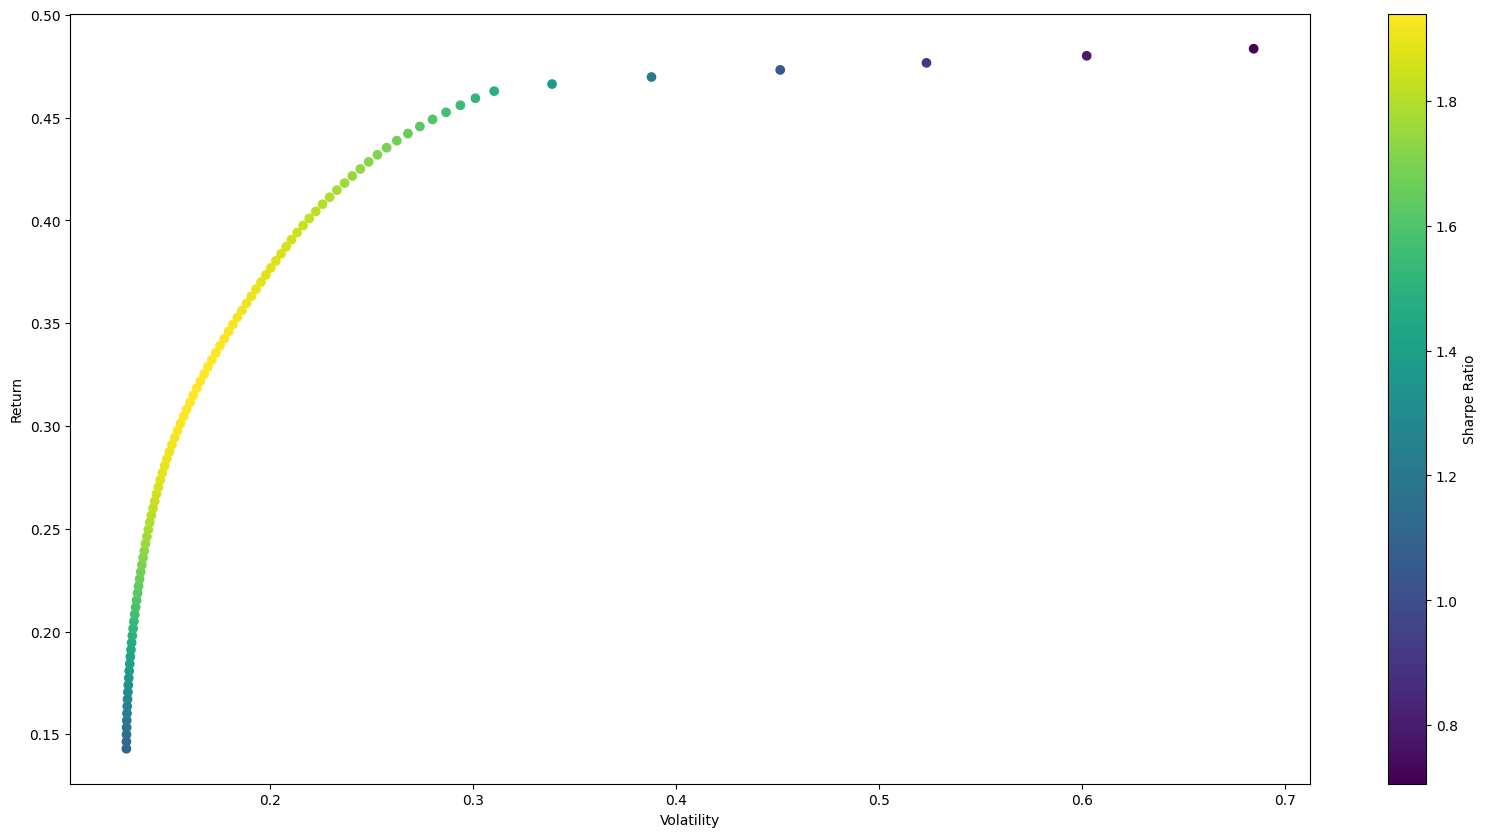

In [11]:
w = w_min   ### w is now optimal portfolio weights, sum to 1
num_ports = 100
gap = (np.amax(r) - ret(r,w_min))/num_ports 
### np.amax in numpy returns max in the array -- since weights sum to 1 and are bounded in (0,1). max portf ret is amax(r)
### The aboove range given by gap starts at ret given by Min Var Portf to Max of all mean returns -- maximum possibe

all_weights = np.zeros((num_ports, len(trainingset.columns)))   ### all_weights is 2D 100 x 24 zero matrix
### Note: len(trainingset.columns) is 24 -- there are 24 stocks here
### print(np.shape(all_weights)) gives (100,24) -- same as print(all_weights.shape) that gives (100,24)

print("******************************************************************")
##########################################################################################################################

ret_arr = np.zeros(num_ports) ### this is a 1-tuple of 100 zeros
vol_arr = np.zeros(num_ports)

for i in range(num_ports): ### this means looping from i=0 to 1,2,3,4,....,99 (100 loops in total)
    port_ret = ret(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(trainingset.shape[1]),r],[1,port_ret],[1,port_ret])
      ### Above, objective minimization is doubly constrained to have wts sum to one and Sum wts x rets sum to port_ret
    
    ### Create x0: initial guesses for weights.
    x0 = w_min
    ### Define a function for portfolio volatility.
    portfstderr = lambda w1: np.sqrt(np.dot(w1,np.dot(w1,decovar))*252)
    optweight = minimize(portfstderr,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)
    
    all_weights[i,:]=optweight.x  ### 24 x 1 optimal wts at row i, formed using decovar
    ret_arr[i]=port_ret
    vol_arr[i]=vol(optweight.x,decovar)

### Indented paras after "for i..." form the loop
    
sharpe_arr = ret_arr/vol_arr  ### sharpe_arr is 100 x 1 array since it is ret_arr[100]/vol_arr[100] element by element

plt.figure(figsize=(20,10)) ### optimal frontier using training set and decovar
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis') 
### in plt.scatter, c is a scalar or sequence of n numbers to be mapped to colors using cmap 
### in plt, for sequential plots, 'viridis' gives colors across the 3D representation of vol_arr, ret_arr, sharpe_arr
### c= in front of third dimension sharpe_arr gives the colors in that dimension, otherwise dots will be all blue
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [12]:
print(sharpe_arr)

[1.104 1.131 1.157 1.183 1.209 1.234 1.259 1.284 1.309 1.333 1.358 1.381
 1.405 1.428 1.451 1.473 1.495 1.517 1.538 1.559 1.58  1.6   1.62  1.639
 1.658 1.677 1.695 1.713 1.73  1.747 1.764 1.779 1.794 1.809 1.823 1.836
 1.849 1.861 1.872 1.883 1.892 1.9   1.908 1.914 1.92  1.925 1.929 1.932
 1.935 1.937 1.939 1.939 1.939 1.939 1.937 1.936 1.933 1.931 1.928 1.924
 1.92  1.916 1.911 1.906 1.901 1.896 1.89  1.884 1.879 1.873 1.866 1.86
 1.853 1.845 1.836 1.826 1.815 1.804 1.792 1.779 1.765 1.751 1.737 1.722
 1.707 1.69  1.671 1.649 1.627 1.603 1.578 1.551 1.525 1.49  1.375 1.211
 1.048 0.911 0.797 0.706]


In [13]:
print(all_weights.shape)

(100, 24)


In [14]:
np.set_printoptions(suppress = True, precision=3) 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(all_weights)

[[0.    0.    0.    ... 0.005 0.165 0.   ]
 [0.    0.    0.    ... 0.005 0.161 0.   ]
 [0.    0.    0.    ... 0.005 0.158 0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


In [15]:
print(all_weights .dot(np.ones(24))) ### check if for each of the 100 portfolio on eff frontier, wts sum to one

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


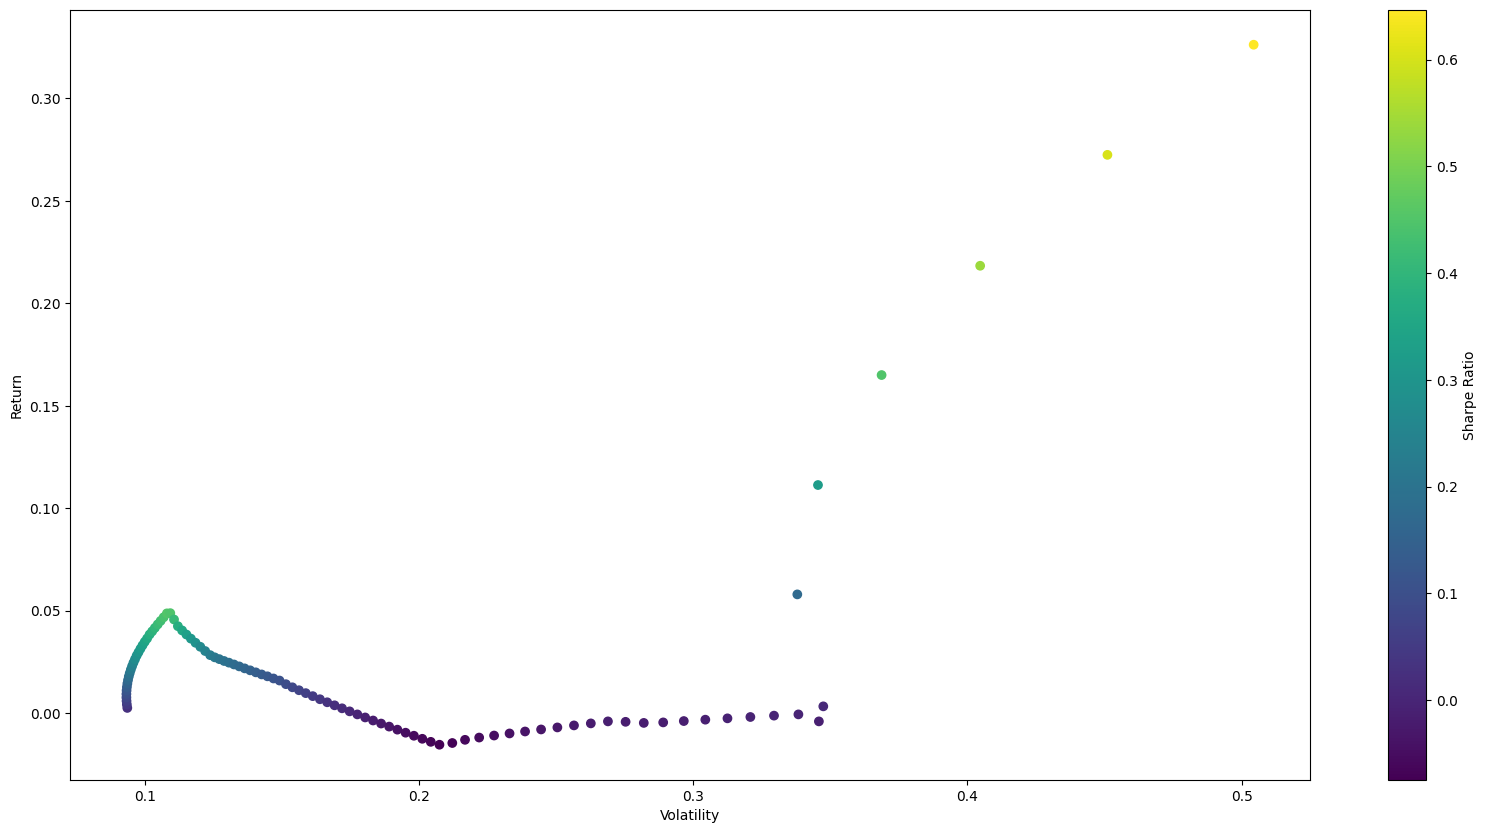

In [16]:
### Below the test set data is used with the optimal wts computed with training set to form the eff portf frontier
testcovar=testset.cov()
testr = np.mean(testset,axis=0)*252 

### initialize
testport_ret = np.zeros(num_ports)
testport_vol = np.zeros(num_ports)

for i in range(num_ports):
    testport_ret[i] = ret(testr,all_weights[i,:])
    testport_vol[i]= vol(all_weights[i,:],testcovar)
    
testport_sharpe = testport_ret/testport_vol

plt.figure(figsize=(20,10))  ### optimal frontier using test set and decovar
plt.scatter(testport_vol, testport_ret, c=testport_sharpe, cmap='viridis') 
### in plt.scatter, c is a scalar or sequence of n numbers to be mapped to colors using cmap 
### in plt, for sequential plots, 'viridis' gives colors across the 3D representation of vol_arr, ret_arr, sharpe_arr
### c= in front of third dimension sharpe_arr gives the colors in that dimension, otherwise dots will be all blue
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [17]:
print(testport_ret)

[ 0.003  0.004  0.006  0.008  0.009  0.011  0.013  0.014  0.016  0.018
  0.019  0.021  0.023  0.025  0.026  0.028  0.03   0.031  0.033  0.035
  0.036  0.038  0.04   0.042  0.043  0.045  0.047  0.049  0.049  0.046
  0.042  0.04   0.038  0.036  0.034  0.032  0.03   0.028  0.027  0.026
  0.025  0.025  0.024  0.023  0.022  0.021  0.02   0.019  0.018  0.017
  0.016  0.014  0.013  0.011  0.01   0.008  0.007  0.005  0.004  0.002
  0.001 -0.001 -0.002 -0.004 -0.005 -0.007 -0.008 -0.01  -0.011 -0.013
 -0.014 -0.015 -0.015 -0.013 -0.012 -0.011 -0.01  -0.009 -0.008 -0.007
 -0.006 -0.005 -0.004 -0.004 -0.005 -0.005 -0.004 -0.003 -0.003 -0.002
 -0.001 -0.001 -0.004  0.003  0.058  0.111  0.165  0.218  0.272  0.326]


In [18]:
print(testport_vol)

[0.094 0.093 0.093 0.093 0.093 0.093 0.093 0.094 0.094 0.094 0.095 0.095
 0.095 0.096 0.096 0.097 0.098 0.098 0.099 0.1   0.101 0.102 0.103 0.104
 0.105 0.106 0.107 0.108 0.109 0.111 0.112 0.114 0.115 0.117 0.119 0.12
 0.122 0.124 0.126 0.127 0.129 0.131 0.133 0.134 0.136 0.138 0.14  0.143
 0.145 0.147 0.149 0.151 0.154 0.156 0.159 0.161 0.164 0.167 0.169 0.172
 0.175 0.178 0.18  0.183 0.186 0.189 0.192 0.195 0.198 0.201 0.204 0.207
 0.212 0.217 0.222 0.227 0.233 0.239 0.245 0.25  0.257 0.263 0.269 0.275
 0.282 0.289 0.297 0.304 0.312 0.321 0.329 0.338 0.346 0.347 0.338 0.345
 0.369 0.405 0.451 0.504]


In [19]:
print(all_weights[0:20,:])

[[0.    0.    0.    0.    0.    0.137 0.015 0.    0.    0.036 0.027 0.
  0.101 0.    0.    0.    0.    0.09  0.307 0.06  0.057 0.005 0.165 0.   ]
 [0.    0.    0.    0.    0.    0.138 0.016 0.    0.    0.038 0.026 0.
  0.098 0.    0.    0.    0.    0.089 0.309 0.058 0.061 0.005 0.161 0.   ]
 [0.    0.    0.    0.    0.    0.14  0.016 0.    0.    0.041 0.026 0.
  0.094 0.    0.    0.    0.    0.089 0.311 0.057 0.064 0.005 0.158 0.   ]
 [0.    0.    0.    0.    0.    0.141 0.017 0.    0.    0.043 0.025 0.
  0.09  0.    0.    0.    0.    0.089 0.312 0.055 0.068 0.004 0.155 0.   ]
 [0.    0.    0.    0.    0.    0.142 0.018 0.    0.    0.046 0.024 0.
  0.087 0.    0.    0.    0.    0.089 0.314 0.054 0.071 0.004 0.152 0.   ]
 [0.    0.    0.    0.    0.    0.144 0.018 0.    0.    0.048 0.023 0.
  0.083 0.    0.    0.    0.    0.089 0.316 0.052 0.075 0.004 0.148 0.   ]
 [0.    0.    0.    0.    0.    0.145 0.019 0.    0.    0.051 0.022 0.
  0.079 0.    0.    0.    0.    0.089 0.317 0.05  0.0

In [20]:
print(testr)

BroadR       0.204632
IntelR       0.225270
MicroCR      0.071833
MicronR      0.262756
QualR       -0.021806
SamR        -0.051485
SKR          0.081670
SMICR        0.093388
AliR        -0.199983
AmazR        0.021125
EbayR        0.756070
RakR         0.446730
SunR        -0.906423
WayR         0.379485
ZalR         0.271807
JDR         -0.364407
TysonR       0.284453
PepsicoR    -0.040782
NestleR      0.123623
MondelezR    0.108762
KweichowR   -0.059943
DiageoR      0.378728
DanoneR      0.239929
AnheuserR    0.021732
dtype: float64
